In [2]:
%load_ext Cython

In [3]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from scipy import interpolate

import itertools
import collections
import urllib.request as request

# Local Binary Patterns

## Circularly Symmetric Neighbor Set

We define a texture *T* as the collection of pixels in a gray scale image

$$T = t(g_c, g_0, ..., g_{P-1})$$

where $p_c$ is the value of the center pixel and $g_p$ corresponds to the value of a local neighboor. To calculate the coordinates of a neighbor we need the following formulas
$$i = -R\sin\big(\frac{2\pi p}{ P}\big)$$

and

$$j = R\cos\big(\frac{2\pi p}{P}\big)$$

In [48]:
%%cython
from libc.math cimport sin, cos, pi, ceil, floor
import numpy as np
cimport numpy as np

def calculate_neighborhood(int x0, int y0, int P, int R):
    cdef int p
    cdef np.ndarray[np.double_t, ndim=2] neighbors = np.zeros([P, 2], dtype=np.double)
    
    for p in range(P):
        neighbors[p, 0] = x0 + R * cos(2 * pi * p / P)
        neighbors[p, 1] = y0 - R * sin(2 * pi * p / P)
    
    return neighbors

In [49]:
def plot_neigborhood(x, y):
    plt.scatter(x, y)
    plt.axis('square')
    plt.grid(True)
    plt.xticks(np.arange(-2, 3, 1.0))
    plt.yticks(np.arange(-2, 3, 1.0))
    plt.show()

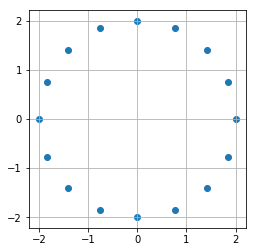

In [50]:
R = 2
P = 16
x0 = 0
y0 = 0

coordinates = calculate_neighborhood(x0, y0, P, R)

x = coordinates[:, 0]
y = coordinates[:, 1]

plot_neigborhood(x, y)

### Interpolation

When a neighbor is not located in the center of a pixel, that neighbor value should be calculated by interpolation. Thus, we need to define a function that given a coordinate, interpolates the value.

In [40]:
%%cython
from libc.math cimport sin, cos, pi, ceil, floor
import numpy as np
cimport numpy as np
from libc.stdlib cimport abort, malloc, free

cdef double get_pixel2d(
    double *image,
    Py_ssize_t n_rows, 
    Py_ssize_t n_cols,
    long x,
    long y) nogil:
    
    if (y < 0) or (y >= n_rows) or (x < 0) or (x >= n_cols):
        return 0
    else:
        return image[y * n_cols + x]

cdef double bilinear_interpolation(
    double *image,
    Py_ssize_t n_rows,
    Py_ssize_t n_cols,
    double x,
    double y) nogil:
    
    cdef double d_y, d_x, top_left, top_right, bottom_left, bottom_right
    cdef long min_y, min_x, max_y, max_x

    min_y = <long>floor(y)
    min_x = <long>floor(x)
    max_y = <long>ceil(y)
    max_x = <long>ceil(x)
    
    d_y = y - min_y
    d_x = x - min_x
    
    top_left = get_pixel2d(image, n_rows, n_cols, min_x, min_y)
    top_right = get_pixel2d(image, n_rows, n_cols, max_x, min_y)
    bottom_left = get_pixel2d(image, n_rows, n_cols, min_x, max_y)
    bottom_right = get_pixel2d(image, n_rows, n_cols, max_x, max_y)
    
    top = (1 - d_x) * top_left + d_x * top_right
    bottom = (1 - d_x) * bottom_left + d_x * bottom_right

    return (1 - d_y) * top + d_y * bottom

In [41]:
%timeit -n100 jdd(gray_img, 204, 20, 16, 2)

3.05 µs ± 395 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
def calculate_neiborhood_values(neigborhood, interpolation_function):
    gray_values = np.apply_along_axis(lambda pt: interpolation_function(*pt), axis=1, arr=neigborhood)
    return gray_values.ravel()

In [ ]:
%%cython
import numpy as np
cimport numpy as np
from scipy import interpolate
cimport cython
from libc.math cimport sin, cos, pi
from libc.stdlib cimport abort, malloc, free    

cdef calculate_neighborhood(int x0, int y0, int P, int R) nogil:
    cdef int p
    cdef np.ndarray[np.double_t, ndim=2] neighbors = np.zeros([P, 2], dtype=np.double)
    
    for p in range(P):
        neighbors[p, 0] = x0 + R * cos(2 * pi * p / P)
        neighbors[p, 1] = y0 - R * sin(2 * pi * p / P)
    
    return neighbors

@cython.boundscheck(False)
@cython.wraparound(False)
cdef test(int n):
    cdef int i
    cdef int x0 = 0
    cdef int y0 = 0
    cdef int P = 16
    cdef int R = 2

    for i in xrange(n):
        calculate_neighborhood(x0, y0, P, R)

In [ ]:
%%time
test(600*600)

### Joint Difference Distribution

The joint difference distribution is a highly discriminative texture operator. It records the ocurrences of various patterns in the neighborhood of each pixel in a P-dimentional histogram.

$$T \approx t(g_0 - g_c, g_1 - g_c, ... g_{p-1} - g_c)$$

where $g_0$ is the gray value of the center pixel and $g_p$ is the gray value of the $p$ neighbor. This distribution is invariant against gray-scale shifts.

In [ ]:
cdef double *joint_difference_distribution(
    double *image,
    Py_ssize_t n_rows,
    Py_ssize_t n_cols,
    int x0,
    int y0,
    int P,
    int R
) nogil:
    cdef Py_ssize_t p
    cdef double *T = <double *> malloc(sizeof(double) * P)
    cdef double x, y, gp
    
    if T is NULL:
        abort()
        
    gc = get_pixel2d(image, n_rows, n_cols, x0, y0)
    
    for p in range(P):
        x = x0 + R * cos(2 * pi * p / P)
        y = y0 - R * sin(2 * pi * p / P)
        gp = bilinear_interpolation(image, n_rows, n_cols, x, y)
        T[p] = gp - gc
    
    return T

## Binary Joint Distribution

In [ ]:
cdef int *binary_joint_distribution(double *T, Py_ssize_t T_size) nogil:
    cdef int *s_T = <int *> malloc(sizeof(int) * T_size)
    cdef Py_ssize_t i = 0
    
    for t in range(T_size):
        if T[t] >= 0.0:
            s_T[t] = 1
        else:
            s_T[t] = 0
    
    return s_T

### Local Binary Pattern

$LBP_{P,R}$ operater is by definition invariant against any monotonic transformation of the gray scale. As long as the order of the gray values stays the same, the output of the $LBP_{P,R}$ operator remains constant.

$$LBP_{P,R} = \sum_{p=0}^{P-1} s(g_p - g_c) 2^p$$

where 

$$s(x) = 
\begin{cases} 
    1 & x\geq0 \\
    0 & x<0
\end{cases}
$$

In [ ]:
def LBP(gray_img, center_coordinates, P, R):
    s = binary_joint_distribution(gray_img, center_coordinates, P, R)
    p = np.arange(0, P)
    binomial_factor = 2 ** p
    return np.sum(binomial_factor * s)

### Uniform Local Binary Patterns

In [3], Ojala mentions that in their practical experience LBP is not a good discriminator. They propose just to select the set of local binary patterns such that the number of spatial transitions (bitwise 0/1 changes) does not exeed 2. 

For example, the pattern '1111' has 0 spatial transitions, the pattern '1100' has 1 spatial transitions and the pattern '1101' has 2 spatial transitions. Thus, the uniform local binary patterns are defined as:

$$LBP_{P,R}^{u2} = 
\begin{cases} 
    \sum_{p=0}^{P-1} s(g_p - g_c) & U(LBP_{P,R}) \leq 2 \\
    P + 1 & otherwise,
\end{cases}
$$

where

$$U(LBP_{P, R}) = |s(g_{P-1} - g_c) - s(g_0 - g_c)| + \sum_{p=1}^{P-1} |s(g_p - g_c) - s(g_{p-1} - g_c)|$$

Given that the number of uniform patterns is finite. We can create a hash table with the pre-values of $LBP_{P,R}^{u2}$ just for the uniform patterns. 

In [ ]:
@jit(nopython=True)
def is_uniform(pattern):
    count = 0
    for idx in range(len(pattern) - 1):
        count += pattern[idx] ^ pattern[idx + 1]
        if count > 2:
            return False
    return True

@jit(nopython=True)
def uniform_patterns(P):
    patterns = itertools.product([0, 1], repeat=P)
    u_patterns = [pattern for pattern in patterns if is_uniform(pattern)]
    
    return [''.join(str(elem) for elem in elems) for elems in u_patterns]

In [ ]:
@jit(nopython=True)
def LBP_uniform(gray_img, center_coordinates, P, R, uniform_patterns):
    s = binary_joint_distribution(gray_img, center_coordinates, P, R)
    pattern = ''.join([str(elem) for elem in s])
    p = np.arange(0, P)
    binomial_factor = 2 ** p
    
    return sum(s) if pattern in uniform_patterns else P + 1 

## Conversion RGB a YUV

According to [1], converting from RGB to Y'UV we need the following equations:

$$Y' = W_R R + W_G G + W_b B$$

$$U = U_{max} \frac{B - Y'}{1 - W_B}$$

$$V = V_{max} \frac{R - Y'}{1 - W_R}$$

$$W_R = 0.299;\hspace{0.5em}W_G = 1 - W_R - W_B;\hspace{0.5em}W_B = 0.114;\hspace{0.5em}U_{max} = 0.436;\hspace{0.5em}V_{max} = 0.615$$

where R, G, B are the matrix representation of red, green and blue channels. The previous equations, can be represented as a matrix multiplication

$$
\begin{bmatrix}
        Y'  \\
        U \\
        V
\end{bmatrix} =
\begin{bmatrix}
        0.299 & 0.587 & 1.114 &  \\
        -0.14713 & -0.28886 & 0.436 \\
        0.615 & -0.51499 & -0.10001
\end{bmatrix}
\begin{bmatrix}
        R  \\
        G \\
        B
\end{bmatrix}
$$

*Hint: I took more precise weights from [2]

In [ ]:
def rgb2yuv(rgb):
    error_message = 'The image must be RBG'
    assert len(rgb.shape)== 3, error_message
    assert rgb.shape[-1] == 3, error_message
    
    W = np.array([
        [ 0.299     ,  0.587     ,  0.114      ],
        [-0.14714119, -0.28886916,  0.43601035 ],
        [ 0.61497538, -0.51496512, -0.10001026 ]
    ])
    
    return rgb @ W.T

# Color Moments

### Mean
$$\mu_i = \frac{1}{N} \sum_{j=1}^N p_{ij}$$

where *N* is the number of pixes in the image and $p_{ij}$ is the value of the j-th pixel of the i-th color channel. 

### Standard Deviation

$$\sigma_i = \sqrt{\frac{1}{N} \sum_{j=1}^N (p_{ij} - \mu_i) ^ 2}$$

where $\mu_i$ is the mean of the i-th color channel.

In [ ]:
def color_moment(image, order=1):
    dim = image.ndim
    axis = tuple([i for i in range(img.ndim - 1)])
    
    if order == 1:
        return np.mean(image, axis=axis)
    if order == 2:
        return np.std(image, axis=axis)
    else:
        raise ValueError('Order should be 1 for mean or 2 for std')

## Auxiliary Functions

In [7]:
def load_image(url, as_gray=False):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, as_gray=as_gray, plugin='pil')

import skimage.color

url = 'https://www.propertyfinder.ae/property/9607847b4ffe15366c4cae076dafb4f3/668/452/MODE/e71028/5993980-3b974o.webp'
img = load_image(url, False)
img_rgb = skimage.color.rgba2rgb(img)

In [ ]:
axis = tuple([i for i in range(img.ndim - 1)])
np.mean(img, axis=axis)

In [ ]:
color_moment(img_rgb, order=1)

In [ ]:
rgb2yuv(img_rgb)

In [8]:
gray_img = skimage.color.rgb2gray(img_rgb)

# R = 2
# P = 16
# center_coordinates = [301, 305]
# u_patterns = uniform_patterns(P)

In [ ]:
%%time
print('The binary joint distribution is:', binary_joint_distribution(gray_img, center_coordinates, P, R))

In [ ]:
%%time
print('The LBP value is:', LBP(gray_img, center_coordinates, P, R))

In [ ]:
%%time
print('The LBP uniform value is:', LBP_uniform(gray_img, center_coordinates, P, R, u_patterns))

In [ ]:
@jit(nopython=True, parallel=True)
def test(gray_img, P, R, u_patterns):
    h, w = gray_img.shape
    lbp_uniform = np.zeros((w, h))
    
    for i in range(20):
        for j in range(20):
            lbp_uniform[i, j] = LBP_uniform(gray_img, (i, j), P, R, u_patterns)

In [ ]:
test(gray_img, P, R, u_patterns)

In [ ]:
from skimage.feature import local_binary_pattern

features = local_binary_pattern(gray_img, 16, 2, 'nri_uniform')

In [ ]:
y, x, z = plt.hist(features.ravel(), bins=int(np.max(features)))

In [50]:
%%cython

cpdef bilinear_interpolation(double[:, ::1] image, double x, double y):
    cdef Py_ssize_t n_rows
    cdef Py_ssize_t n_cols
    
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    
    return _bilinear_interpolation(&image[0][0], n_rows, n_cols, x, y)


Error compiling Cython file:
------------------------------------------------------------
...
    cdef Py_ssize_t n_cols
    
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    
    return _bilinear_interpolation(&image[0][0], n_rows, n_cols, x, y)
          ^
------------------------------------------------------------

/home/rocampo/.cache/ipython/cython/_cython_magic_ab56621a90a1fa8d68c29369629ea236.pyx:9:11: undeclared name not builtin: _bilinear_interpolation

Error compiling Cython file:
------------------------------------------------------------
...
    cdef Py_ssize_t n_cols
    
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    
    return _bilinear_interpolation(&image[0][0], n_rows, n_cols, x, y)
                                  ^
------------------------------------------------------------

/home/rocampo/.cache/ipython/cython/_cython_magic_ab56621a90a1fa8d68c29369629ea236.pyx:9:35: Cannot convert 'double *' to Python object


TypeError: object of type 'NoneType' has no len()

In [47]:
def jdd(double[:, ::1] image,int x0, int y0, int P, int R):
    cdef Py_ssize_t n_rows, n_cols
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    
    T = joint_difference_distribution(&image[0][0], n_rows, n_cols, x0, y0, P, R)
    
    T_nopoint = [p for p in T[:P]]
    
    s_T = binary_joint_distribution(T, P)
    
    return [p for p in s_T[:P]]

SyntaxError: invalid syntax (<ipython-input-47-ea37f9005785>, line 1)

[1] https://www.itu.int/dms_pubrec/itu-r/rec/bt/R-REC-BT.601-7-201103-I!!PDF-E.pdf

[2] https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py#L384

[3] Ojala, T., Pietikäinen, M., & Mäenpää, T. (2002). Multiresolution gray-scale and rotation invariant texture classification with local binary patterns. IEEE Transactions on Pattern Analysis and Machine Intelligence, 24(7), 971–987.